# PCA of EEG Features (Dortmund Dataset)
This notebook describes the process of applying PCA to EEG-derived features, exploring dimensionality reduction, and preparing data for clustering.

- Objective: Reduce high-dimensional EEG features to a lower-dimensional space to explore participant variability.
- Dataset: Dortmund dataset (608 participants, multiple EEG features).
- Goals:
  1. Understand structure of the features.
  2. Perform PCA for dimensionality reduction.
  3. Explore variance explained by principal components.
  4. Prepare data for clustering and visualization.

## Load Data
Load the Dortmund dataset and inspect the first few rows.

In [1]:
import pandas as pd
import numpy as np

dort = pd.read_csv("./dataset/Dortmund_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_dort = pd.read_csv("./dataset/Dortmund_age&sex.csv", index_col=0)
# Extract age and sex
age_dort = age_sex_dort['age'].values
sex_dort = age_sex_dort['sex'].values

lemon = pd.read_csv("./dataset/Lemon_features.csv", index_col=0)  # Keep subject IDs as index!
age_sex_lemon = pd.read_csv("./dataset/Lemon_age&sex.csv", index_col=0)
# Extract age and sex
age_lemon = age_sex_lemon['age_group'].values # note ages are ranges in Lemon
sex_lemon = age_sex_lemon['sex'].values

## 1. Exploratory Data Analysis
- Preview first few rows and numeric columns.
- Check for missing values.
- Examine feature distributions.

In [2]:
# Print dataset shapes
print(f"Dortmund_features.csv shape: {dort.shape}")
print(f"LEMON_features.csv shape: {lemon.shape}\n")

dort_cols = set(dort.columns)
lemon_cols = set(lemon.columns)

print("Features only in Dortmund:")
print(dort_cols - lemon_cols, "\n")

print("Features only in LEMON:")
print(lemon_cols - dort_cols, "\n")


Dortmund_features.csv shape: (600, 147)
LEMON_features.csv shape: (190, 147)

Features only in Dortmund:
set() 

Features only in LEMON:
set() 



All features are shared in Dortmund and Lemon

1. Scatter Plot of First Two Raw Features


Plotting the first two numeric features:
Feature 1: nl_rqa mean diag length
Feature 2: kurtosis_amp_theta



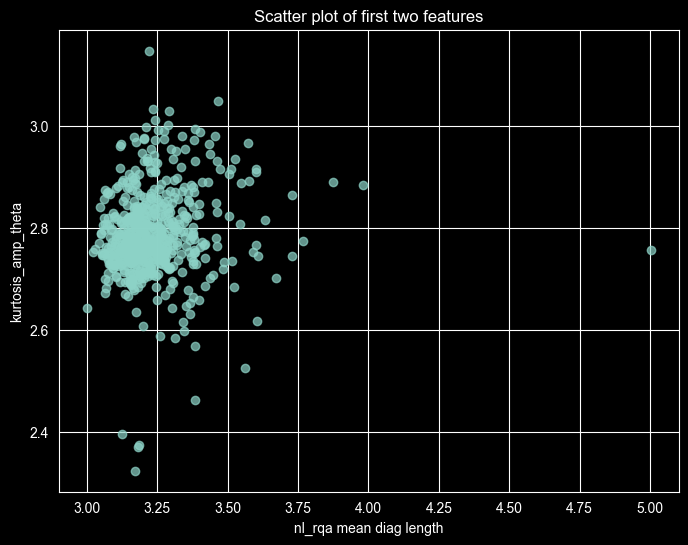

In [3]:
import matplotlib.pyplot as plt

# Select only numeric columns (exclude IDs or non-numeric)
numeric_data = dort.select_dtypes(include=['float64', 'int64'])
dort_numeric = numeric_data.values

# Define features (all numeric columns)
features = dort_numeric  # shape: (participants, features)

# Print what we are plotting
print("Plotting the first two numeric features:")
print(f"Feature 1: {numeric_data.columns[0]}")
print(f"Feature 2: {numeric_data.columns[1]}\n")

# Scatter plot of first two features
plt.figure(figsize=(8,6))
plt.scatter(features[:, 0], features[:, 1], alpha=0.7)
plt.xlabel(numeric_data.columns[0])
plt.ylabel(numeric_data.columns[1])
plt.title("Scatter plot of first two features")
plt.grid(True)
plt.show()


2. Feature-Age/Sex Relationship
-   **Age** — plotted using scatter plots
-   **Sex** — plotted using boxplots (female vs male)

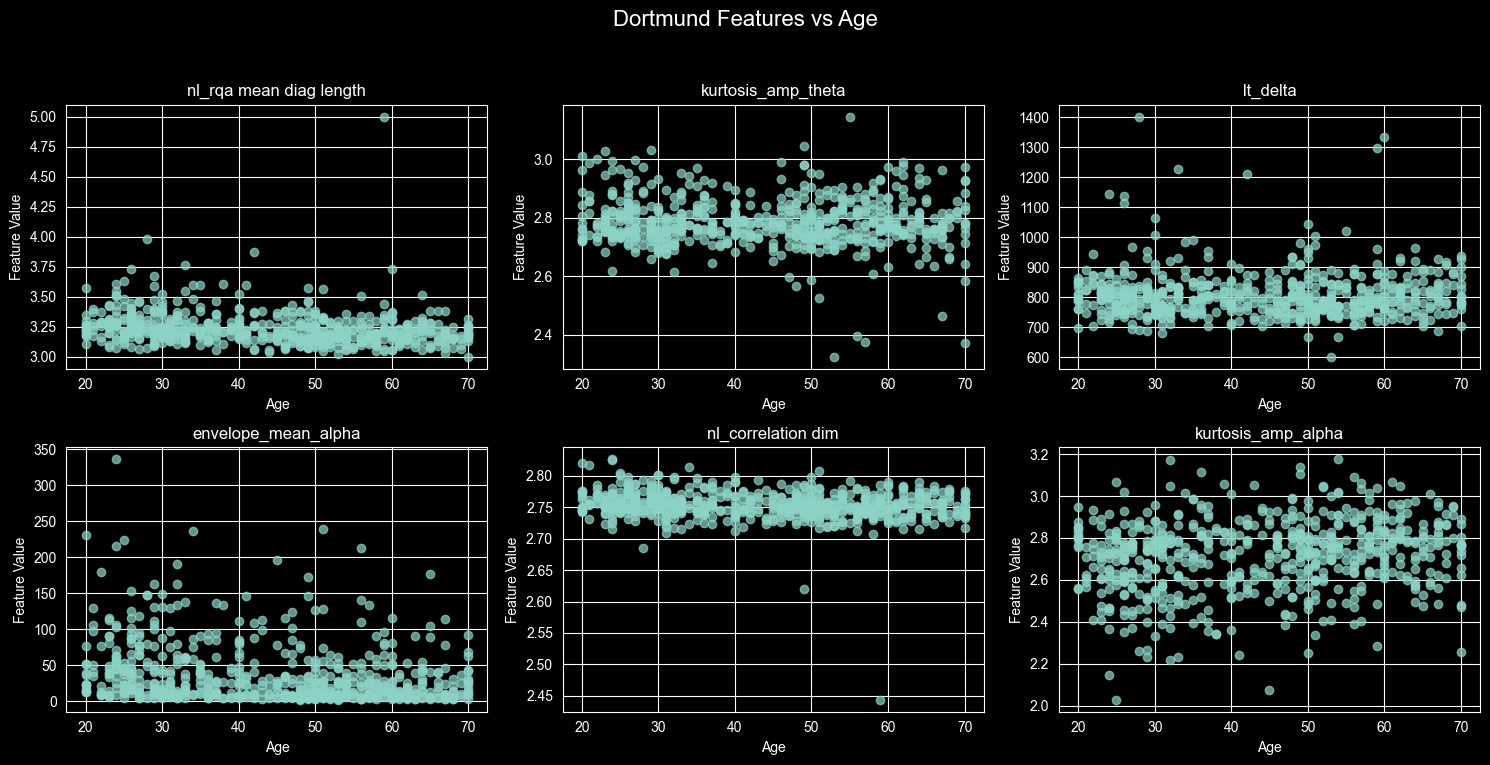

C:\Users\alewo\AppData\Local\Temp\ipykernel_7224\479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
C:\Users\alewo\AppData\Local\Temp\ipykernel_7224\479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
C:\Users\alewo\AppData\Local\Temp\ipykernel_7224\479824353.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
C:\Users\alew

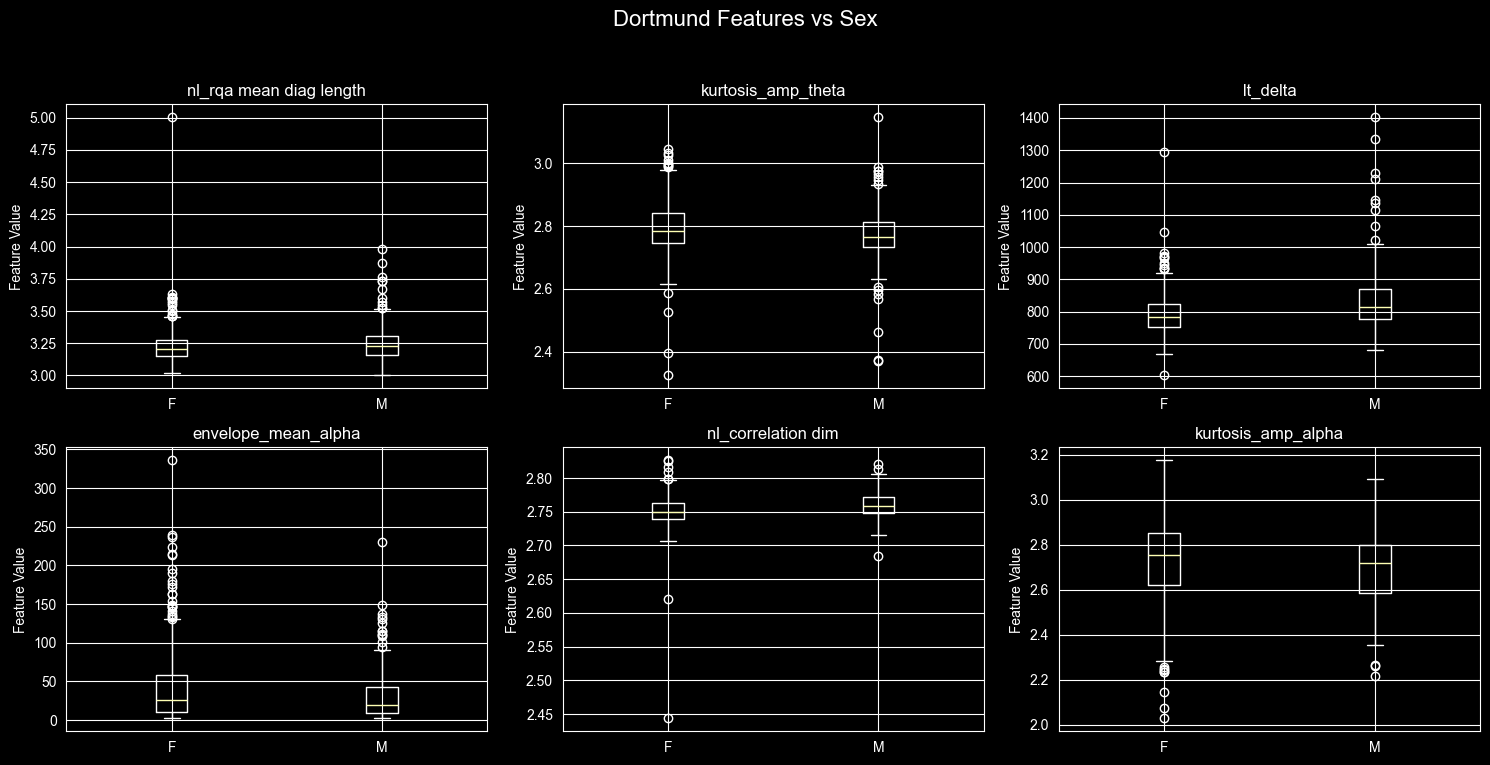

In [4]:
# Numeric Dortmund features
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
num_features_to_plot = 6

# -------------------------
# Plot features vs Age
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].scatter(age_dort, dort_numeric.iloc[:, i], alpha=0.7)
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_xlabel("Age")
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Age", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# -------------------------
# Plot features vs Sex
# -------------------------
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i in range(num_features_to_plot):
    axes[i].boxplot([dort_numeric.iloc[sex_dort=='F', i], dort_numeric.iloc[sex_dort=='M', i]],
                    labels=['F','M'])
    axes[i].set_title(dort_numeric.columns[i])
    axes[i].set_ylabel("Feature Value")

plt.suptitle("Dortmund Features vs Sex", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2. Principal Component Analysis (PCA)
- Reduce dimensionality to an optimal number of PCs for clustering while optionally visualizing in 2D.
- Examine explained variance, singular values, and component loadings to understand feature contributions.


1. Standardize Features
- PCA is sensitive to scale, so all numeric features are standardized to mean = 0 and variance = 1 before PCA.

2. Optimal PCA Computation
- Compute full PCA and determine the minimum number of PCs needed to reach a threshold variance (default 80%).
- Plot cumulative explained variance and scree plot to visualize the variance captured by each component.

3.  PCA Component Loadings & Transformed Data
- Loadings indicate how strongly each original feature contributes to each principal component.
- Transformed PCA data (scores) are used for clustering.
- Optionally export loadings and PCA-transformed dataset for further analysis.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def run_optimal_pca(data, threshold=0.8, dataset_name="Dataset", export=False):
    """
    Standardizes data, computes full PCA, finds optimal PCs using cumulative variance,
    plots PCA results, and returns PCA-transformed data and components.

    Parameters:
        data : pandas DataFrame (numeric)
        threshold : float, e.g. 0.8 for 80% variance
        dataset_name : str (used in plot titles)

    Returns:
        pca_optimal_components : np.array (PCA-transformed data)
        pca_model_optimal : PCA object fitted with optimal n_components
        num_pcs_threshold : int (optimal number of PCs)
        explained_variance_full : np.array (all PCs variance)
        components_optimal : np.array (loadings)
    """

    # 1. Standardize
    scaled = StandardScaler().fit_transform(data)

    # 2. Full PCA
    pca_full = PCA()
    pca_full.fit(scaled)

    explained_variance_full = pca_full.explained_variance_ratio_
    cumulative = np.cumsum(explained_variance_full)

    # 3. Determine optimal PCs
    num_pcs_threshold = np.argmax(cumulative >= threshold) + 1

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Cumulative plot
    axes[0].plot(range(1, len(cumulative)+1), cumulative*100, marker='o')
    axes[0].axvline(num_pcs_threshold, color='r', linestyle='--',
                    label=f'{int(threshold*100)}% at PC{num_pcs_threshold}')
    axes[0].set_title(f"{dataset_name}: Cumulative Explained Variance")
    axes[0].set_xlabel("Number of Principal Components")
    axes[0].set_ylabel("Cumulative Explained Variance (%)")
    axes[0].legend()
    axes[0].grid(True)

    # Scree plot
    axes[1].plot(range(1, len(explained_variance_full)+1),
                 explained_variance_full*100, marker='o', alpha=0.7)
    axes[1].axhline(explained_variance_full[num_pcs_threshold-1]*100,
                    color='r', linestyle='--',
                    label=f'PC{num_pcs_threshold} variance')
    axes[1].set_title(f"{dataset_name}: Scree Plot")
    axes[1].set_xlabel("Principal Component")
    axes[1].set_ylabel("Explained Variance (%)")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # 4. Run optimal PCA
    pca_optimal = PCA(n_components=num_pcs_threshold)
    transformed = pca_optimal.fit_transform(scaled)

    # --- Printing ---
    print(f"\n=== {dataset_name}: Optimal PCA Summary ===")
    print(f"Optimal number of PCs for {int(threshold*100)}% variance: {num_pcs_threshold}")
    print(f"Variance explained by PC1: {explained_variance_full[0]*100:.2f}%")
    print(f"Total variance explained by {num_pcs_threshold} PCs: {cumulative[num_pcs_threshold-1]*100:.2f}%\n")

    print("\n=== Explained Variance of Optimal PCs ===")
    for i, v in enumerate(pca_optimal.explained_variance_ratio_, start=1):
        print(f"PC{i}: {v*100:.2f}%")

    print("\n=== First 5 Singular Values ===")
    print(pca_optimal.singular_values_[:5])

    print("\n=== PCA Loadings (First 3 Features Per PC) ===")
    for i, pc in enumerate(pca_optimal.components_, start=1):
        print(f"PC{i}: {pc[:3]}")


    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    # --------------------------- #
    # 5. Optional export to CSV
    # --------------------------- #
    if export:
        # --- PCA Components (Loadings) ---
        # Rows = PCs, Columns = original features
        # This shows HOW MUCH each original feature contributes to each PC
        loadings_df = pd.DataFrame(
            pca_optimal.components_,
            columns=data.columns,
            index=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        loadings_path = f"dataset/{dataset_name}_pca_loadings.csv"
        loadings_df.to_csv(loadings_path, index=True)

        # --- PCA Transformed Data ---
        # Rows = Subjects, Columns = PCs
        # This is what you use for CLUSTERING
        transformed_df = pd.DataFrame(
            transformed,
            index=data.index, # Keep original subject IDs!
            columns=[f"PC{i+1}" for i in range(num_pcs_threshold)]
        )
        transformed_path = f"dataset/{dataset_name}_pca.csv"
        transformed_df.to_csv(transformed_path, index=True)

        print(f"\n✓ Exported loadings to:     {loadings_path}")
        print(f"✓ Exported PCA scores to:   {transformed_path}")
        print(f"  Subject IDs preserved: {transformed_df.index[:3].tolist()}... (first 3)")

    return transformed, pca_optimal, num_pcs_threshold, explained_variance_full, pca_optimal.components_


OPTIMAL PCA (DORTMUND DATASET):

data_pca      → The PCA-transformed dataset (participants × optimal PCs).
                These are the coordinates of each subject in PCA space.

data_model    → The fitted PCA model object.
                Contains components_, explained_variance_ratio_, singular_values_, etc.

data_nPC      → The optimal number of principal components selected automatically.
                Determined by reaching the cumulative variance threshold (e.g., 80%).

data_var      → Explained variance ratio of each selected PC.
                Tells you how much variance each principal component captures.

data_loadings → PCA loadings (components): contribution of each original feature to each PC.
                Shape = (nPC × n_features). Used for interpretation and clustering.

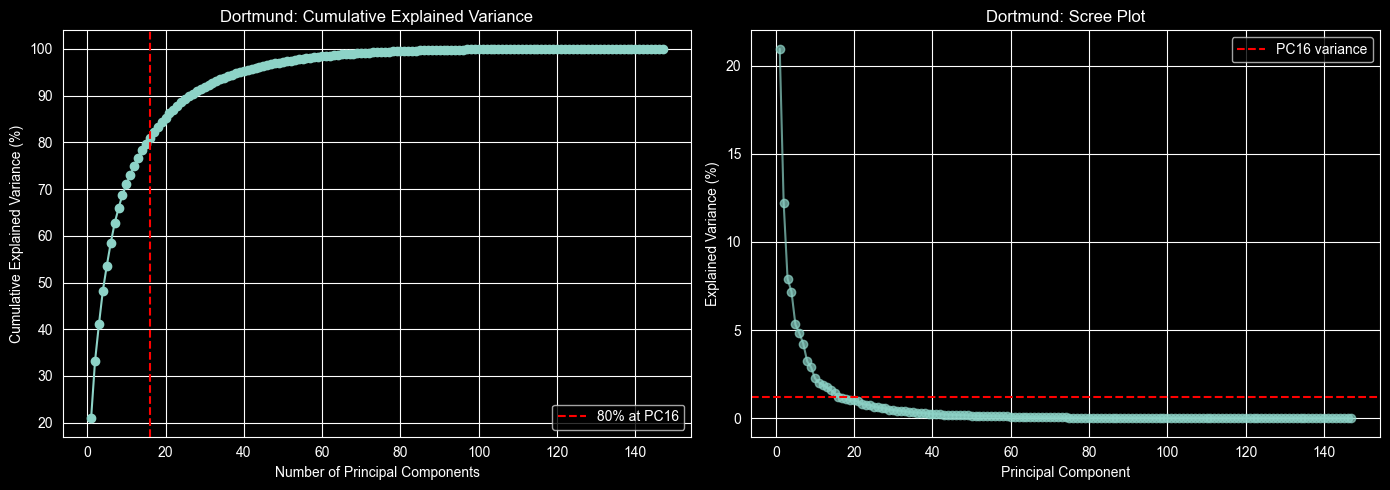


=== Dortmund: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 16
Variance explained by PC1: 20.95%
Total variance explained by 16 PCs: 80.96%


=== Explained Variance of Optimal PCs ===
PC1: 20.95%
PC2: 12.23%
PC3: 7.91%
PC4: 7.18%
PC5: 5.32%
PC6: 4.83%
PC7: 4.24%
PC8: 3.23%
PC9: 2.90%
PC10: 2.26%
PC11: 2.02%
PC12: 1.89%
PC13: 1.76%
PC14: 1.61%
PC15: 1.43%
PC16: 1.22%

=== First 5 Singular Values ===
[135.92426733 103.85380041  83.50298096  79.57932545  68.48214712]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [ 0.07755219  0.03162877 -0.02748839]
PC2: [-0.17531188 -0.01302006 -0.1249459 ]
PC3: [-0.05802997 -0.06893857 -0.1305787 ]
PC4: [-0.01288499  0.02623767 -0.0957521 ]
PC5: [ 0.06349532 -0.1289768  -0.02706481]
PC6: [0.03376724 0.01408464 0.08135488]
PC7: [0.08086674 0.08480603 0.04429421]
PC8: [-0.07386023  0.09192019 -0.09997259]
PC9: [0.00609931 0.06766717 0.07690553]
PC10: [-0.02057908 -0.11699303 -0.03645007]
PC11: [0.00525763 0.2361399  0.10385898]
P

In [6]:
dort_numeric = dort.select_dtypes(include=['float64', 'int64'])
dort_pca, dort_model, dort_nPC, dort_var, dort_loadings = run_optimal_pca(
    dort_numeric,
    threshold=0.80,
    dataset_name="Dortmund",
    export=True
)

OPTIMAL PCA (LEMON DATASET):

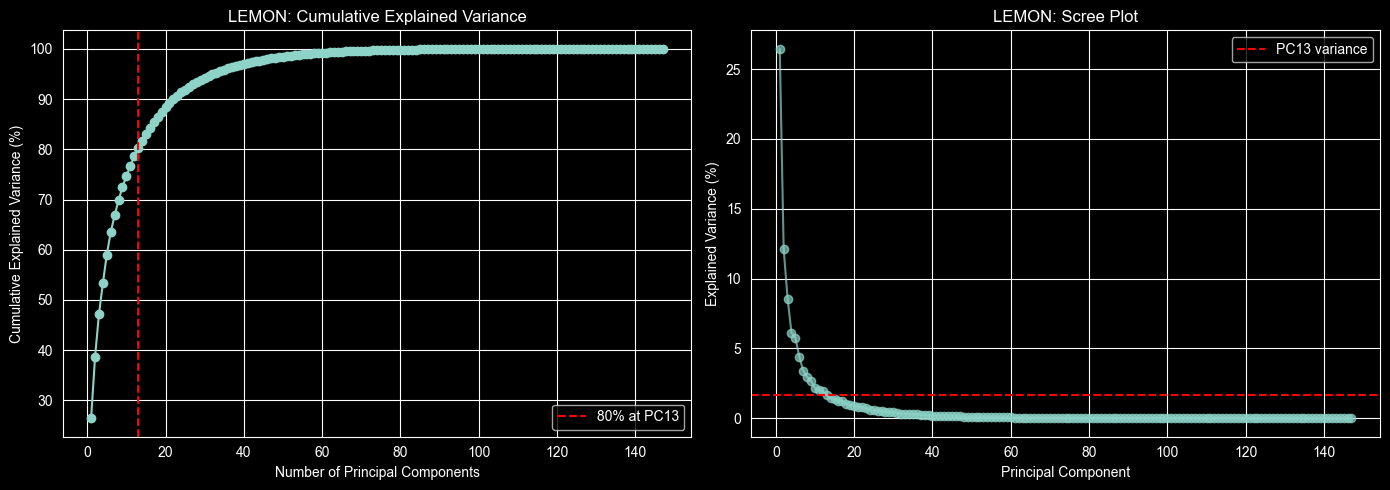


=== LEMON: Optimal PCA Summary ===
Optimal number of PCs for 80% variance: 13
Variance explained by PC1: 26.45%
Total variance explained by 13 PCs: 80.24%


=== Explained Variance of Optimal PCs ===
PC1: 26.45%
PC2: 12.15%
PC3: 8.57%
PC4: 6.13%
PC5: 5.75%
PC6: 4.41%
PC7: 3.40%
PC8: 2.96%
PC9: 2.68%
PC10: 2.15%
PC11: 2.01%
PC12: 1.93%
PC13: 1.64%

=== First 5 Singular Values ===
[85.9498367  58.24597055 48.9346571  41.37887684 40.0681235 ]

=== PCA Loadings (First 3 Features Per PC) ===
PC1: [0.1183683  0.00626448 0.06426968]
PC2: [-0.01681211  0.05213916 -0.10845719]
PC3: [ 0.04190047 -0.01404165  0.09092072]
PC4: [-0.00944458  0.11810503  0.12506928]
PC5: [0.15848921 0.02815616 0.03572152]
PC6: [-0.0697668  -0.02414548 -0.02613632]
PC7: [ 0.03277971  0.0790457  -0.14885173]
PC8: [-0.02086367 -0.14332598  0.05058819]
PC9: [ 0.00972326  0.17819356 -0.03012205]
PC10: [ 0.07506859 -0.07097608  0.02327065]
PC11: [-0.00868137 -0.18580685 -0.04964539]
PC12: [ 0.00321458 -0.22565086  0.10436

In [7]:
lemon_numeric = lemon.select_dtypes(include=['float64', 'int64'])
lemon_pca, lemon_model, lemon_nPC, lemon_var, lemon_loadings = run_optimal_pca(
    lemon_numeric,
    threshold=0.8,
    dataset_name="LEMON",
    export=True
)


## 3. PCA Stability Analysis: Bootstrap
To assess the stability of PCA-derived feature subspaces for two datasets (Dortmund and Lemon) - understand how robust the principal components are to sampling variability

1. **Bootstrap Resampling:**
 - For each dataset, we create `n_boot` resampled datasets by sampling subjects with replacement.
- PCA is applied to each resampled dataset, keeping components that explain 99% of the variance.

2. **Subspace Comparison:**
- For each pair of bootstrap PCA results within the same dataset, we compute the singular values of the matrix product between their component matrices.
- Singular values close to 1 = nearly identical subspaces (high stability)
- Also compute singular values between Dortmund and Lemon bootstraps to see how similar the feature subspaces are across datasets.

In [40]:
from numpy.linalg import svd
from sklearn.utils import resample

def bootstrap_pca(X, n_boot, variance_threshold=0.99):
    """
    Compute PCA on multiple bootstrap resamples of the dataset to assess stability.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The data matrix to analyze.
    - n_boot: int
        Number of bootstrap resamples.
    - variance_threshold: float
        Fraction of variance to retain in PCA.

    Returns:
    - components_boot: list of arrays
        Each array contains PCA components for one bootstrap sample (shape: n_features x n_components).
    - min_n_comp: int
        Minimum number of components across all bootstrap samples.
    """

    n_samples, n_features = X.shape
    components_boot = []
    min_n_comp = n_features

    for i in range(n_boot):
        # Resample rows (participants) with replacement
        X_resampled = resample(X, random_state=i)

        # Standardize resampled data
        X_scaled = StandardScaler().fit_transform(X_resampled)

        # Fit PCA to bootstrap-sampled data
        pca = PCA(n_components=variance_threshold)
        pca.fit(X_scaled)

        # Store the component vectors
        components_boot.append(pca.components_.T)   # shape: features × components

        # Keep track of minimum number of components across bootstraps
        min_n_comp = np.min((min_n_comp, len(pca.components_)))

    return components_boot, min_n_comp



def singular_values(mat1, mat2):
    """
    Measure similarity between two PCA component matrices using singular values.

    Parameters:
    - mat1, mat2: arrays of shape (n_features, n_components)

    Returns:
    - Array of singular values representing alignment of subspaces.
    """

    M = mat1.T @ mat2
    _, s, _ = svd(M)
    return s

In [41]:
def run_permutation_test(X, n_perms=100):
    """
    Generate a null distribution of eigenvalues by permuting features independently.
    Rule out sample size artifacts (Johnstone 2001).
    """
    null_eigenvalues = []
    for i in range(n_perms):
        # Shuffle each column independently to destroy correlations
        X_permuted = np.apply_along_axis(np.random.permutation, 0, X)
        X_scaled = StandardScaler().fit_transform(X_permuted)

        pca = PCA()
        pca.fit(X_scaled)
        null_eigenvalues.append(pca.explained_variance_)

    return np.array(null_eigenvalues)

# Run permutation tests to establish baselines
perm_ev_dort = run_permutation_test(dort, n_perms=100)
perm_ev_lem = run_permutation_test(lemon, n_perms=100)

In [31]:
# Number of bootstrap iterations
n_boot = 200  # For readability in examples; typically use >=100 in actual analysis

# Variance threshold for bootstrap PCA (use 0.80 to match the 80% threshold used in main PCA)
bootstrap_variance_threshold = 0.80

# Run bootstrap PCA on Dortmund and LEMON datasets
dort_comp, min_dort = bootstrap_pca(dort, n_boot, variance_threshold=bootstrap_variance_threshold)
lem_comp, min_lem = bootstrap_pca(lemon, n_boot, variance_threshold=bootstrap_variance_threshold)

min_n_comp = np.min((min_dort, min_lem))

dort_comp = [boot[:, :min_n_comp] for boot in dort_comp]
lem_comp = [boot[:, :min_n_comp] for boot in lem_comp]
# have aligned PCA bases of shape (features, min_n_com

In [32]:
# Bootstrap PCA on PERMUTED data (null baseline) - destroys correlation structure
dort_perm_comp, lem_perm_comp = [], []
min_dort_perm, min_lem_perm = dort.shape[1], lemon.shape[1]

for i in range(n_boot):
    for X, comp_list, min_holder, name in [
        (dort.values, dort_perm_comp, 'dort', 'Dortmund'),
        (lemon.values, lem_perm_comp, 'lem', 'Lemon')
    ]:
        X_permuted = np.apply_along_axis(np.random.permutation, 0, X.copy())
        X_resampled = resample(X_permuted, random_state=i)
        X_scaled = StandardScaler().fit_transform(X_resampled)

        pca = PCA(n_components=bootstrap_variance_threshold)
        pca.fit(X_scaled)
        comp_list.append(pca.components_.T)

for i in range(n_boot):
    min_dort_perm = min(min_dort_perm, dort_perm_comp[i].shape[1])
    min_lem_perm = min(min_lem_perm, lem_perm_comp[i].shape[1])

min_n_comp_perm = min(min_dort_perm, min_lem_perm)
dort_perm_comp = [boot[:, :min_n_comp_perm] for boot in dort_perm_comp]
lem_perm_comp = [boot[:, :min_n_comp_perm] for boot in lem_perm_comp]

In [33]:
# Compute pairwise singular values between bootstrap samples
results = {"within_Dortmund": {}, "within_Lemon": {}, "between_DL": {}}

# Compute singular values within bootstraps:
for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(dort_comp):
        if j > i: # only upper-triangle comparisons to avoid duplicates
            results["within_Dortmund"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

for i, boot1 in enumerate(lem_comp):
    for j, boot2 in enumerate(lem_comp):
        if j > i: # only upper-triangle comparisons to avoid duplicates
            results["within_Lemon"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

for i, boot1 in enumerate(dort_comp):
    for j, boot2 in enumerate(lem_comp):
        if j >= i: # compare each Dortmund bootstrap to corresponding or later LEMON bootstraps
            results["between_DL"][f"boots {i}-{j}"] = singular_values(boot1, boot2)


In [34]:
# permuted baseline
permuted_results = {"within_Dortmund": {}, "within_Lemon": {}, "between_DL": {}}

for i, boot1 in enumerate(dort_perm_comp):
    for j, boot2 in enumerate(dort_perm_comp):
        if j > i:
            permuted_results["within_Dortmund"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

for i, boot1 in enumerate(lem_perm_comp):
    for j, boot2 in enumerate(lem_perm_comp):
        if j > i:
            permuted_results["within_Lemon"][f"boots {i}-{j}"] = singular_values(boot1, boot2)

for i, boot1 in enumerate(dort_perm_comp):
    for j, boot2 in enumerate(lem_perm_comp):
        if j >= i:
            permuted_results["between_DL"][f"boots {i}-{j}"] = singular_values(boot1, boot2)




### Results

##### Within-Dataset Stability (Lemon-Lemon or Dortmund):
All within-Lemon bootstrap similarity distributions fall extremely close to **1.0**, with most values in the range **0.98–1.00**.
This indicates:
- *High cluster stability:* each component is internally consistent.
- *Robust centroid estimation:* resampling does not meaningfully shift the cluster centers.
- *Well-separated structure:* there is no sign of component collapse or merging.

In short, the Lemon dataset exhibits **very strong internal reproducibility**.

In [ ]:
# Display results
# - High singular values (~1) indicate strong alignment of PCA subspaces
# - Lower singular values indicate differences between subspaces

results["within_Dortmund"]

In [ ]:
results["within_Lemon"]

##### Cross-Dataset Similarity (Dortmund vs. Lemon)
Cross-dataset bootstrap similarities fall in the range:
- **~0.20–0.27** at the high end
- rapidly dropping toward **0.01–0.0001**

1. **Minimal structural alignment between the datasets.**
   The components extracted from Dortmund do not resemble those from Lemon.

2. **No evidence of shared component geometry.**
   If the datasets had corresponding factors or clusters, we would expect cross-dataset similarities closer to **0.6–0.9**.
   Instead, values are an order of magnitude lower.

3. **Clear separability.**
   The between-dataset similarity distributions never overlap with the within-dataset distributions (0.98–1.00 vs. 0.00–0.27).
   This is strong evidence that the datasets express **distinct underlying patterns**.
This pattern indicates:
results["between_DL"]

## Visualising Bootstraping with Eigenvalues

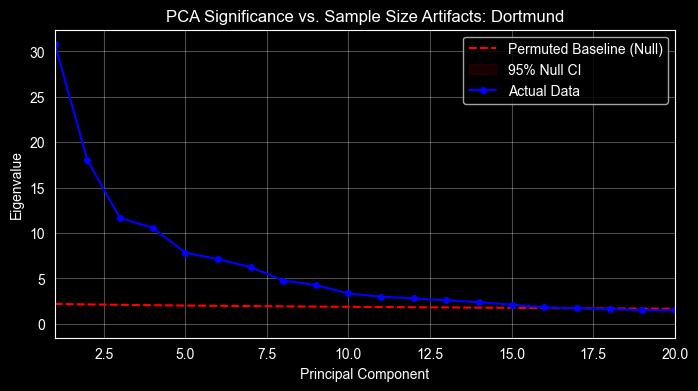

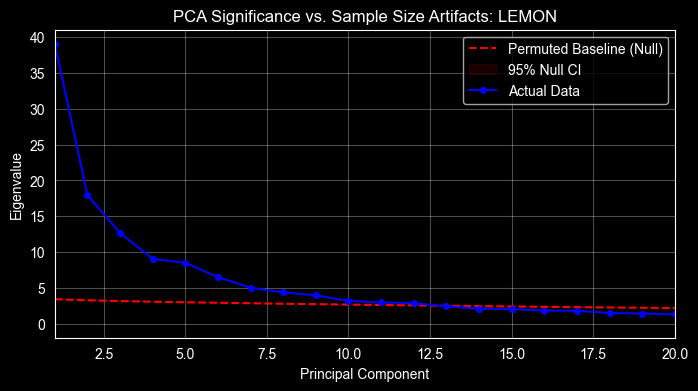

In [35]:
import matplotlib.pyplot as plt

def plot_eigenvalue_significance(X, perm_ev, title):

    # Fit real PCA for comparison
    X_scaled = StandardScaler().fit_transform(X)
    real_pca = PCA().fit(X_scaled)
    real_ev = real_pca.explained_variance_

    plt.figure(figsize=(8, 4))

    # Plot Null Distribution (Permuted)
    mean_perm = np.mean(perm_ev, axis=0)
    plt.plot(range(1, len(mean_perm)+1), mean_perm, 'r--', label='Permuted Baseline (Null)')
    plt.fill_between(range(1, len(mean_perm)+1),
                     np.percentile(perm_ev, 5, axis=0),
                     np.percentile(perm_ev, 95, axis=0),
                     color='red', alpha=0.1, label='95% Null CI')

    # Plot Real Data
    plt.plot(range(1, len(real_ev)+1), real_ev, 'b-o', label='Actual Data', markersize=4)

    plt.title(f"PCA Significance vs. Sample Size Artifacts: {title}")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    plt.xlim(1, 20) # Focus on top components
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_eigenvalue_significance(dort, perm_ev_dort, "Dortmund")
plot_eigenvalue_significance(lemon, perm_ev_lem, "LEMON")

### Note
The Significance Scree Plots show that the eigenvalues of the Actual Data (Blue) significantly exceed the Permuted Baseline (Red) for the first ~10-15 principal components. This indicates that these initial components capture genuine structure in the EEG data, while later components likely represent noise artifacts.

## Viasualising Bootstraping with Singular Values


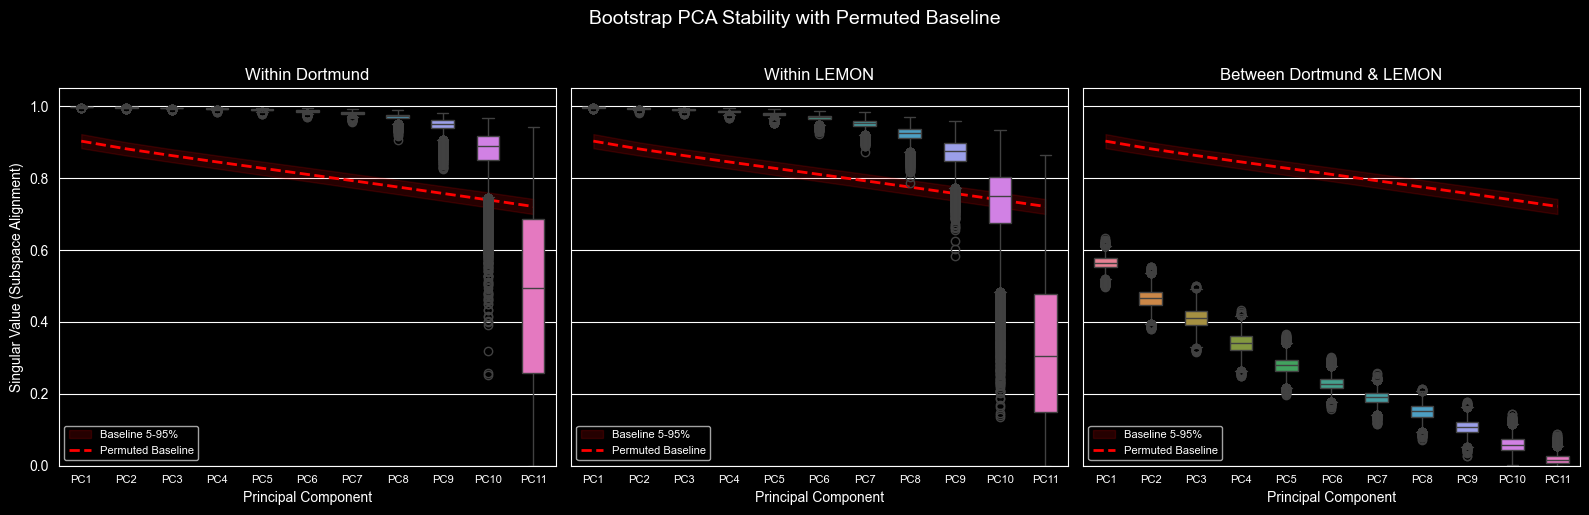

In [47]:
import seaborn as sns

comparison_types = ["within_Dortmund", "within_Lemon", "between_DL"]
titles = ["Within Dortmund", "Within LEMON", "Between Dortmund & LEMON"]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, comp_type, title in zip(axes, comparison_types, titles):
    actual_svals = np.array(list(results[comp_type].values()))
    permuted_svals = np.array(list(permuted_results[comp_type].values()))

    n_comp = min(actual_svals.shape[1], permuted_svals.shape[1], min_n_comp)
    actual_svals = actual_svals[:, :n_comp]
    permuted_svals = permuted_svals[:, :n_comp]

    # Build dataframe for boxplot
    df = pd.DataFrame(actual_svals, columns=[f"PC{i+1}" for i in range(n_comp)])
    df_melt = df.melt(var_name="PC", value_name="Singular Value")

    # Baseline stats
    permuted_mean = np.mean(permuted_svals, axis=0)
    permuted_5th = np.percentile(permuted_svals, 5, axis=0)
    permuted_95th = np.percentile(permuted_svals, 95, axis=0)
    x = np.arange(n_comp)

    # Baseline shading and line
    ax.fill_between(x, permuted_5th, permuted_95th, color='red', alpha=0.15, label='Baseline 5-95%')
    ax.plot(x, permuted_mean, 'r--', linewidth=2, label='Permuted Baseline')



    # Boxplot for actual data
    sns.boxplot(data=df_melt, x="PC", y="Singular Value", ax=ax, width=0.5, hue="PC", palette="husl", legend=False)

    ax.set_xlabel("Principal Component")
    ax.set_title(title)
    ax.set_ylim(0, 1.05)
    ax.legend(loc='lower left', fontsize=8)
    ax.set_xticks(x)
    ax.set_xticklabels([f"PC{i+1}" for i in x], fontsize=8)

axes[0].set_ylabel("Singular Value (Subspace Alignment)")
plt.suptitle("Bootstrap PCA Stability with Permuted Baseline", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()



### Interpretation with Baseline

The permuted baseline represents the expected singular values when comparing PCA subspaces from **random (uncorrelated) data**.

**Key findings:**
1. **Within-dataset comparisons (Dortmund & LEMON):** Actual singular values are substantially above the permuted baseline, especially for the first few principal components. This confirms that the PCA subspace is **genuinely stable** - not an artifact of the analysis.

2. **Between-dataset comparison:** Singular values closer to or overlapping with the permuted baseline suggest that any apparent alignment between Dortmund and LEMON subspaces is largely due to chance, confirming that the datasets have **distinct underlying structures**.

3. **Component-by-component:** Components where actual values significantly exceed the baseline are "stable" - they consistently represent the same directions across bootstrap samples. Components near the baseline are unstable/noisy.

### PCA Stability and Cross-Dataset Comparison (Summary)

- **Within Dortmund:** Principal components are highly stable across bootstrap samples (singular values ≈ 0.47–0.998 for PCs 1–11). Leading PCs are extremely robust, while minor components show lower reproducibility.
- **Within LEMON:** Components are stable overall, with singular values ≈ 0.32–0.997. Top components are highly consistent, whereas the least dominant components vary more across bootstrap samples.
- **Between Dortmund and LEMON:** Singular values are low (≈ 0.018–0.565), indicating that PCA subspaces are largely dataset-specific and not strongly shared.

### Conclusion:
- PCA captures stable variance structure within each dataset but differs substantially between datasets.
- PCA representations should be computed separately for Dortmund and LEMON; a single PCA cannot be reliably applied to both datasets for downstream analyses such as clustering.
